## Prepare Environment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import sys

from sklearn import svm, metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
from xgboost import XGBClassifier

try:
    import xgboost as xgb
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb

try:
    import lightgbm as lgb
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
    import lightgbm as lgb


In [15]:
X_test = pd.read_csv("./X_test.csv")
df_y_test = pd.read_csv("./y_test.csv")
y_test = df_y_test.squeeze()
X_train = pd.read_csv("./X_train.csv")
df_y_train = pd.read_csv("./y_train.csv")
y_train = df_y_train.squeeze()

## Ordinal-Aware Evaluation Metrics

Since credit ratings are ordinal, I created metrics (such as ±1, ±2 class) that allow us to evaluate the "closeness" of predictions. By making these into functions, I can apply them to all models to do a more complete evaluation of the predictions.

In [16]:
# Define ordinal-aware evaluation functions
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def tolerance_accuracy(y_true, y_pred, tolerance=1):
    """Calculate accuracy allowing for a tolerance in ordinal predictions"""
    diff = np.abs(y_true - y_pred)
    within_tolerance = (diff <= tolerance).sum()
    return within_tolerance / len(y_true)

def calculate_roc_auc(y_true, y_pred_proba, classes):
    """Calculate ROC AUC for multi-class classification using OvR"""
    try:
        # Binarize the true labels
        y_true_bin = label_binarize(y_true, classes=classes)
        
        # Calculate ROC AUC (macro average)
        if y_pred_proba.shape[1] == len(classes):
            roc_auc = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')
        else:
            roc_auc = None
        return roc_auc
    except Exception as e:
        print(f"  ROC AUC calculation error: {e}")
        return None

def evaluate_ordinal_model(y_true, y_pred, model_name="Model", y_pred_proba=None, classes=None):
    """Comprehensive evaluation for ordinal classification"""
    exact_acc = accuracy_score(y_true, y_pred)
    tol_1_acc = tolerance_accuracy(y_true, y_pred, tolerance=1)
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Calculate ROC AUC if probabilities are provided
    roc_auc = None
    if y_pred_proba is not None and classes is not None:
        roc_auc = calculate_roc_auc(y_true, y_pred_proba, classes)
    
    print(f"\n{model_name} Performance:")
    print(f"  Exact match accuracy: {exact_acc:.4f}")
    print(f"  Within ±1 class: {tol_1_acc:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    if roc_auc is not None:
        print(f"  ROC AUC (macro): {roc_auc:.4f}")
    
    return {
        'exact_accuracy': exact_acc,
        'within_1': tol_1_acc,
        'mae': mae,
        'roc_auc': roc_auc
    }

## Baseline Logistic Regression Model

In [17]:
# Identify feature types
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ],
    remainder='drop'
)

# Baseline model
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train
baseline_pipeline.fit(X_train, y_train)

# Predict
y_pred_baseline = baseline_pipeline.predict(X_test)
y_pred_proba_baseline = baseline_pipeline.predict_proba(X_test)
baseline_classes = baseline_pipeline.named_steps['classifier'].classes_

baseline_linear_metrics = evaluate_ordinal_model(
    y_test, y_pred_baseline, "Baseline Logistic Regression",
    y_pred_proba=y_pred_proba_baseline, classes=baseline_classes
)


Baseline Logistic Regression Performance:
  Exact match accuracy: 0.3724
  Within ±1 class: 0.8310
  Mean Absolute Error: 0.9172
  ROC AUC (macro): 0.8627


## Tuned Logistic Regression Model

In [18]:
# Create pipeline for tuning
tuned_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=5000))
])

# Parameter grid
param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__class_weight': [None, 'balanced']
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create MAE scorer (lower is better, so we need to negate it for maximization)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Randomized search - optimizing for MAE
random_search = RandomizedSearchCV(
    tuned_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=cv_strategy,
    scoring=mae_scorer,  # Changed from 'accuracy' to MAE
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

# Evaluate on test set
y_pred_tuned = random_search.best_estimator_.predict(X_test)
y_pred_proba_tuned = random_search.best_estimator_.predict_proba(X_test)
tuned_classes = random_search.best_estimator_.named_steps['classifier'].classes_

tuned_linear_metrics = evaluate_ordinal_model(
    y_test, y_pred_tuned, "Tuned Logistic Regression",
    y_pred_proba=y_pred_proba_tuned, classes=tuned_classes
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__C=0.31489116479568624, classifier__class_weight=None, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.31489116479568624, classifier__class_weight=None, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.31489116479568624, classifier__class_weight=None, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.31489116479568624, classifier__class_weight=None, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.31489116479568624, classifier__class_weight=None, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=8.471801418819979, classifier__class_weight=None, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=8.471801418819979, classifier__class_weight=None, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.04207988669606638, classifier__class_weight=None, classifier__solver=lbfgs; t

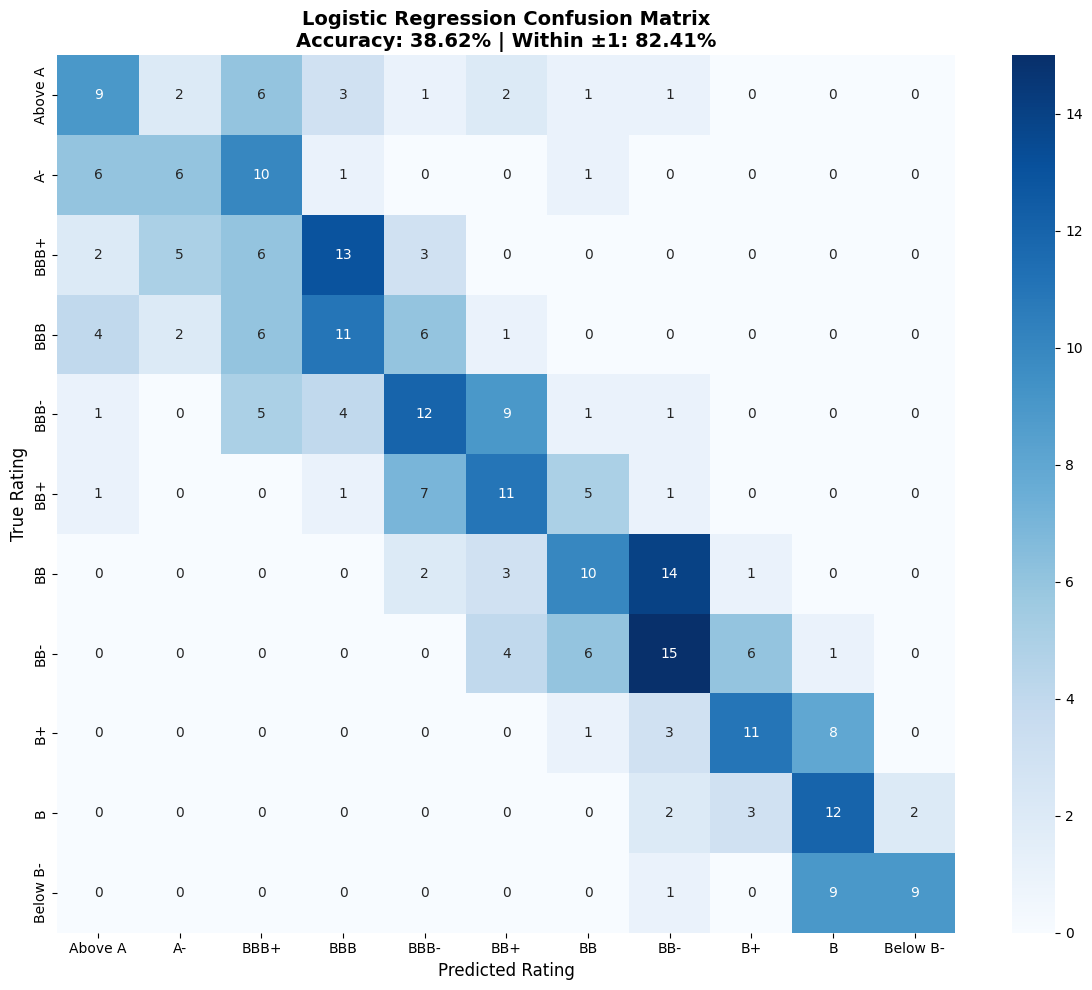


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Above A       0.39      0.36      0.38        25
          A-       0.40      0.25      0.31        24
        BBB+       0.18      0.21      0.19        29
         BBB       0.33      0.37      0.35        30
        BBB-       0.39      0.36      0.38        33
         BB+       0.37      0.42      0.39        26
          BB       0.40      0.33      0.36        30
         BB-       0.39      0.47      0.43        32
          B+       0.52      0.48      0.50        23
           B       0.40      0.63      0.49        19
    Below B-       0.82      0.47      0.60        19

    accuracy                           0.39       290
   macro avg       0.42      0.40      0.40       290
weighted avg       0.40      0.39      0.39       290



In [19]:
# Create rating labels mapping
merged_rating_order_str = ['Above A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'Below B-']
merged_rating_map_num = {rating: i+1 for i, rating in enumerate(merged_rating_order_str)}
inverted_merged_rating_map_str = {v: k for k, v in merged_rating_map_num.items()}

# Get unique classes from the model
classes = random_search.best_estimator_.named_steps['classifier'].classes_
string_labels = [inverted_merged_rating_map_str.get(int(c), str(c)) for c in classes]

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned, labels=classes)
cm_df = pd.DataFrame(cm, index=string_labels, columns=string_labels)

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Logistic Regression Confusion Matrix\nAccuracy: {tuned_linear_metrics["exact_accuracy"]:.2%} | Within ±1: {tuned_linear_metrics["within_1"]:.2%}', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Rating', fontsize=12)
plt.ylabel('True Rating', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print(f"\n{'='*80}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*80}")
print(classification_report(y_test, y_pred_tuned, target_names=string_labels, zero_division=0))

## XGBoost Model

In [20]:
# XGBoost with hyperparameter tuning - OPTIMIZING FOR MAE
# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost requires class labels starting from 0, so adjust the target
y_train_xgb = y_train - 1  # Convert from 1-11 to 0-10
y_test_xgb = y_test - 1

# Create XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mae'))  # Use MAE for training
])

# Parameter grid for XGBoost
xgb_param_distributions = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
}

# MAE scorer for cross-validation
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# RandomizedSearch for XGBoost - OPTIMIZING FOR MAE
xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_distributions,
    n_iter=30,
    cv=cv_strategy,
    scoring=mae_scorer,  # Changed from 'accuracy' to MAE
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_random_search.fit(X_train, y_train_xgb)

# Evaluate on test set (convert predictions back to 1-11 scale)
y_pred_xgb = xgb_random_search.best_estimator_.predict(X_test) + 1
y_pred_proba_xgb = xgb_random_search.best_estimator_.predict_proba(X_test)
xgb_classes = xgb_random_search.best_estimator_.named_steps['classifier'].classes_ + 1  # Convert back to 1-11

xgb_metrics = evaluate_ordinal_model(
    y_test, y_pred_xgb, "XGBoost (MAE-optimized)",
    y_pred_proba=y_pred_proba_xgb, classes=xgb_classes
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

XGBoost (MAE-optimized) Performance:
  Exact match accuracy: 0.7793
  Within ±1 class: 0.8586
  Mean Absolute Error: 0.4000
  ROC AUC (macro): 0.9692

XGBoost (MAE-optimized) Performance:
  Exact match accuracy: 0.7793
  Within ±1 class: 0.8586
  Mean Absolute Error: 0.4000
  ROC AUC (macro): 0.9692


<>:33: SyntaxWarning: invalid escape sequence '\X'
<>:33: SyntaxWarning: invalid escape sequence '\X'
/var/folders/b8/tx0n2hrn1td0rplcz94wqcs40000gn/T/ipykernel_5249/4268236465.py:33: SyntaxWarning: invalid escape sequence '\X'
  print("\XGBoost Accuracy on Test Set:", Accuracy_SVM_tuned)


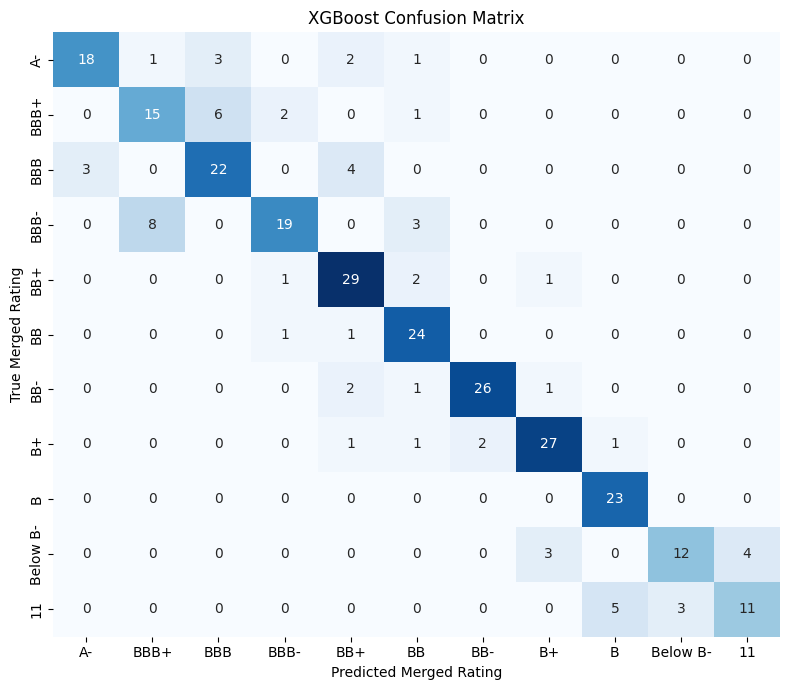

\XGBoost Accuracy on Test Set: 0.7793103448275862

Classification Report XGBoost
              precision    recall  f1-score   support

          A-       0.86      0.72      0.78        25
        BBB+       0.62      0.62      0.62        24
         BBB       0.71      0.76      0.73        29
        BBB-       0.83      0.63      0.72        30
         BB+       0.74      0.88      0.81        33
          BB       0.73      0.92      0.81        26
         BB-       0.93      0.87      0.90        30
          B+       0.84      0.84      0.84        32
           B       0.79      1.00      0.88        23
    Below B-       0.80      0.63      0.71        19
          11       0.73      0.58      0.65        19

    accuracy                           0.78       290
   macro avg       0.78      0.77      0.77       290
weighted avg       0.78      0.78      0.78       290



In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

Accuracy_SVM_tuned = metrics.accuracy_score(y_test, y_pred_xgb)

merged_rating_order_str = ['Above A', 'A-', 'BBB+', 'BBB',
                         'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'Below B-']
merged_rating_map_num = {rating: i for i, rating in enumerate(merged_rating_order_str)}
inverted_merged_rating_map_str = {v: k for k, v in merged_rating_map_num.items()}

cm = confusion_matrix(y_test, y_pred_xgb, labels=xgb_classes)

cm_df = pd.DataFrame(cm, index=xgb_classes, columns=xgb_classes)

string_labels = [inverted_merged_rating_map_str.get(c, str(c)) for c in xgb_classes]

cm_df.index = string_labels
cm_df.columns = string_labels


plt.figure(figsize=(8, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Merged Rating')
plt.ylabel('True Merged Rating')
plt.tight_layout()
plt.show()

# --- Classification Report ---
from sklearn.metrics import classification_report
print("\XGBoost Accuracy on Test Set:", Accuracy_SVM_tuned)
print("\nClassification Report XGBoost")
print(classification_report(y_test, y_pred_xgb, target_names=string_labels, zero_division=0))

## SVM

In [21]:
# --- Step 3: Identify numerical and categorical features ---
column_dtypes_train_filtered = X_train.dtypes
numerical_features_train_filtered = column_dtypes_train_filtered[
    column_dtypes_train_filtered.apply(lambda x: np.issubdtype(x, np.number))
].index.tolist()

categorical_features_train_filtered = X_train.select_dtypes(include='object').columns.tolist()

# --- Step 4: Preprocessing Pipeline ---
preprocessor_svm = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features_train_filtered),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features_train_filtered)
    ],
    remainder='drop'
)

# --- Step 5: Define Model and Pipeline (with probability=True for ROC AUC) ---
svm_clf = svm.SVC(random_state=1234, class_weight='balanced', probability=True)

pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor_svm),
    ('svm', svm_clf)
])

# --- Step 6: Expanded Hyperparameter Search Space ---
param_distributions = {
    'svm__C': loguniform(1e-3, 1e3),
    'svm__gamma': loguniform(1e-4, 1e0),
    'svm__kernel': ['rbf', 'poly', 'sigmoid']
}

# --- Step 7: Cross-validation Strategy ---
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

# --- Step 8: RandomizedSearchCV for Efficiency ---
random_search = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_distributions,
    n_iter=30,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    random_state=1234,
    verbose=2
)

X_train_aligned, y_train_aligned = X_train.align(y_train, join='inner', axis=0)

random_search.fit(X_train_aligned, y_train_aligned)

# --- Step 9: Retrieve and Evaluate Best Model ---
best_params_svm = random_search.best_params_
best_score_svm = random_search.best_score_
best_model_svm = random_search.best_estimator_

y_pred_SVM_tuned = best_model_svm.predict(X_test)
y_pred_proba_svm = best_model_svm.predict_proba(X_test)
svm_classes = best_model_svm.named_steps['svm'].classes_

svm_metrics = evaluate_ordinal_model(
    y_test, y_pred_SVM_tuned, "SVM",
    y_pred_proba=y_pred_proba_svm, classes=svm_classes
)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END svm__C=4.7062107124885095, svm__gamma=0.12174178788224209, svm__kernel=poly; total time=   0.9s
[CV] END svm__C=4.7062107124885095, svm__gamma=0.12174178788224209, svm__kernel=poly; total time=   0.9s
[CV] END svm__C=0.043207151101399784, svm__gamma=0.0012760186458599522, svm__kernel=sigmoid; total time=   0.9s
[CV] END svm__C=4.7062107124885095, svm__gamma=0.12174178788224209, svm__kernel=poly; total time=   1.0s
[CV] END svm__C=0.043207151101399784, svm__gamma=0.0012760186458599522, svm__kernel=sigmoid; total time=   0.9s
[CV] END svm__C=4.7062107124885095, svm__gamma=0.12174178788224209, svm__kernel=poly; total time=   0.9s
[CV] END svm__C=4.7062107124885095, svm__gamma=0.12174178788224209, svm__kernel=poly; total time=   0.9s
[CV] END svm__C=0.043207151101399784, svm__gamma=0.0012760186458599522, svm__kernel=sigmoid; total time=   0.9s
[CV] END svm__C=4.7062107124885095, svm__gamma=0.12174178788224209, svm__kerne

## Linear SVM

In [22]:
# Linear SVM (better for high correlation features) with probability=True for ROC AUC
svm_linear = svm.SVC(kernel='linear', random_state=1234, class_weight='balanced', probability=True)

pipeline_svm_linear = Pipeline(steps=[
    ('preprocessor', preprocessor_svm),
    ('svm', svm_linear)
])

param_distributions_linear = {
    'svm__C': loguniform(1e-2, 1e2),
}

random_search_linear = RandomizedSearchCV(
    pipeline_svm_linear,
    param_distributions=param_distributions_linear,
    n_iter=20,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    random_state=1234,
    verbose=2
)

print("Training Linear SVM...")
random_search_linear.fit(X_train_aligned, y_train_aligned)

y_pred_linear = random_search_linear.best_estimator_.predict(X_test)
y_pred_proba_linear = random_search_linear.best_estimator_.predict_proba(X_test)
linear_svm_classes = random_search_linear.best_estimator_.named_steps['svm'].classes_

linear_svm_metrics = evaluate_ordinal_model(
    y_test, y_pred_linear, "Linear SVM",
    y_pred_proba=y_pred_proba_linear, classes=linear_svm_classes
)

Training Linear SVM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .........................svm__C=0.05835496346821344; total time=   0.4s
[CV] END .........................svm__C=0.05835496346821344; total time=   0.4s
[CV] END .........................svm__C=0.05835496346821344; total time=   0.5s
[CV] END .........................svm__C=0.05835496346821344; total time=   0.4s
[CV] END .........................svm__C=0.05835496346821344; total time=   0.4s
[CV] END .........................svm__C=0.05835496346821344; total time=   0.5s
[CV] END ..........................svm__C=0.5635221042987834; total time=   0.8s
[CV] END ..........................svm__C=0.5635221042987834; total time=   0.9s
[CV] END ..........................svm__C=0.5635221042987834; total time=   0.8s
[CV] END ..........................svm__C=0.5635221042987834; total time=   0.9s
[CV] END ..........................svm__C=0.5635221042987834; total time=   0.8s
[CV] END ................

## Conclusion: Model Comparison

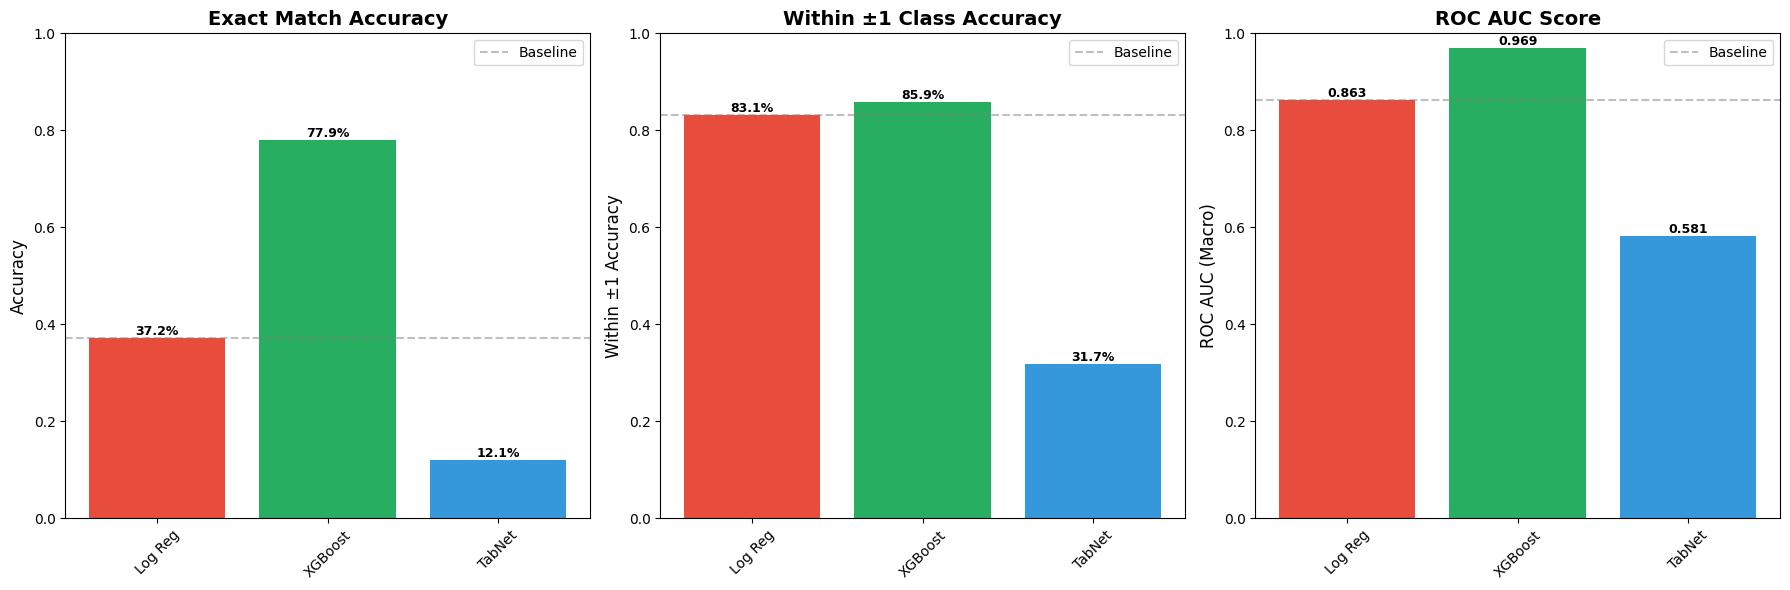


MODEL COMPARISON SUMMARY
Model                    Accuracy    Within ±1      ROC AUC
--------------------------------------------------------------------------------
Log Reg                   37.24%      83.10%       0.8627
XGBoost                   77.93%      85.86%       0.9692
TabNet                    12.07%      31.72%       0.5812


In [28]:
# Visual comparison of all models including ROC AUC
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = ['Log Reg', 'XGBoost', 'TabNet']
accuracies = [baseline_linear_metrics['exact_accuracy'], xgb_metrics['exact_accuracy'], 0.1207]
within_1 = [baseline_linear_metrics['within_1'], xgb_metrics['within_1'], 0.3172]
roc_aucs = [baseline_linear_metrics['roc_auc'], xgb_metrics['roc_auc'], 0.5812]  # AutoML ROC AUC from Vertex AI (AU-ROC)

colors = ['#e74c3c', '#27ae60', '#3498db']

# Accuracy comparison
ax1 = axes[0]
bars1 = ax1.bar(models, accuracies, color=colors)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Exact Match Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.axhline(y=baseline_linear_metrics['exact_accuracy'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{accuracies[i]:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Within ±1 comparison
ax2 = axes[1]
bars2 = ax2.bar(models, within_1, color=colors)
ax2.set_ylabel('Within ±1 Accuracy', fontsize=12)
ax2.set_title('Within ±1 Class Accuracy', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.axhline(y=baseline_linear_metrics['within_1'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{within_1[i]:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# ROC AUC comparison
ax3 = axes[2]
roc_aucs_plot = [r if r is not None else 0 for r in roc_aucs]
bars3 = ax3.bar(models, roc_aucs_plot, color=colors)
ax3.set_ylabel('ROC AUC (Macro)', fontsize=12)
ax3.set_title('ROC AUC Score', fontsize=14, fontweight='bold')
ax3.set_ylim(0, 1.0)
if baseline_linear_metrics['roc_auc'] is not None:
    ax3.axhline(y=baseline_linear_metrics['roc_auc'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
for i, bar in enumerate(bars3):
    height = bar.get_height()
    if roc_aucs[i] is not None:
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{roc_aucs[i]:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(f"{'Model':<20} {'Accuracy':>12} {'Within ±1':>12} {'ROC AUC':>12}")
print("-"*80)
for i, model in enumerate(models):
    roc_str = f"{roc_aucs[i]:.4f}" if roc_aucs[i] is not None else "N/A"
    print(f"{model.replace(chr(10), ' '):<20} {accuracies[i]:>11.2%} {within_1[i]:>11.2%} {roc_str:>12}")
print("="*80)

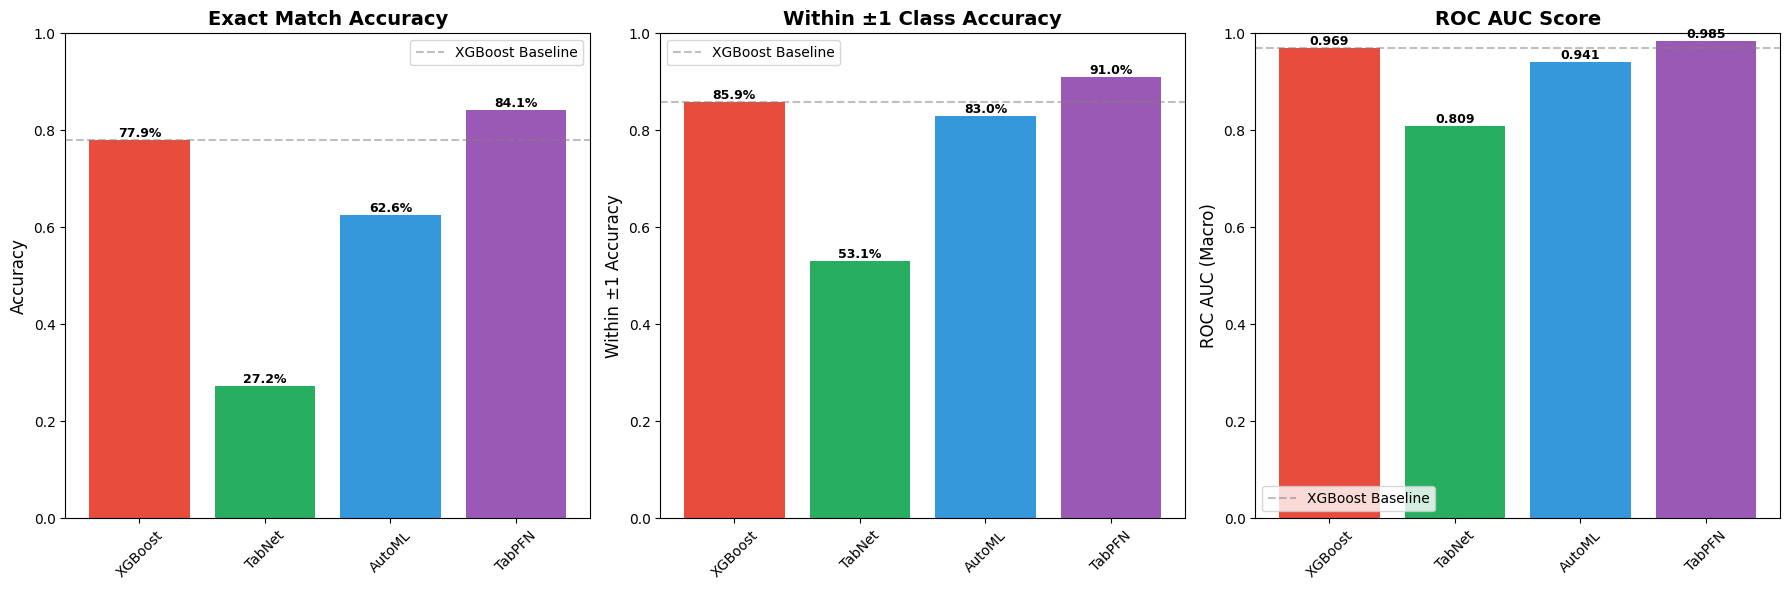


MODEL COMPARISON SUMMARY
Model                    Accuracy    Within ±1      ROC AUC
--------------------------------------------------------------------------------
XGBoost                   77.93%      85.86%       0.9692
TabNet                    27.24%      53.10%       0.8093
AutoML                    62.64%      82.97%       0.9410
TabPFN                    84.14%      91.03%       0.9850


In [5]:
# Visual comparison of all models including ROC AUC
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = ['XGBoost', 'TabNet', 'AutoML', 'TabPFN']
accuracies = [0.7793, 0.2724, 0.6264, 0.84137]
within_1 = [0.8586, 0.5310, 0.8297, 0.9103]
roc_aucs = [0.9692, 0.8093, 0.941, 0.985]  # AutoML ROC AUC from Vertex AI (AU-ROC)

colors = ['#e74c3c', '#27ae60', '#3498db', '#9b59b6']

# Accuracy comparison
ax1 = axes[0]
bars1 = ax1.bar(models, accuracies, color=colors)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Exact Match Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.axhline(y=0.7793, color='gray', linestyle='--', alpha=0.5, label='XGBoost Baseline')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{accuracies[i]:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Within ±1 comparison
ax2 = axes[1]
bars2 = ax2.bar(models, within_1, color=colors)
ax2.set_ylabel('Within ±1 Accuracy', fontsize=12)
ax2.set_title('Within ±1 Class Accuracy', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.axhline(y=0.8586, color='gray', linestyle='--', alpha=0.5, label='XGBoost Baseline')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{within_1[i]:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# ROC AUC comparison
ax3 = axes[2]
roc_aucs_plot = [r if r is not None else 0 for r in roc_aucs]
bars3 = ax3.bar(models, roc_aucs_plot, color=colors)
ax3.set_ylabel('ROC AUC (Macro)', fontsize=12)
ax3.set_title('ROC AUC Score', fontsize=14, fontweight='bold')
ax3.set_ylim(0, 1.0)
ax3.axhline(y=0.9692, color='gray', linestyle='--', alpha=0.5, label='XGBoost Baseline')
for i, bar in enumerate(bars3):
    height = bar.get_height()
    if roc_aucs[i] is not None:
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{roc_aucs[i]:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(f"{'Model':<20} {'Accuracy':>12} {'Within ±1':>12} {'ROC AUC':>12}")
print("-"*80)
for i, model in enumerate(models):
    roc_str = f"{roc_aucs[i]:.4f}" if roc_aucs[i] is not None else "N/A"
    print(f"{model.replace(chr(10), ' '):<20} {accuracies[i]:>11.2%} {within_1[i]:>11.2%} {roc_str:>12}")
print("="*80)